# Model tuning

In [6]:
from sklearn.datasets import load_diabetes

## Regularization

In [7]:
X,y = load_diabetes(return_X_y=True, as_frame=True)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [8]:
y.head()

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

⚠️ Always **scale** features before regularization.

In [9]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
import pandas as pd

In [10]:
linreg = LinearRegression().fit(X, y)
ridge = Ridge(alpha=0.2).fit(X, y)
lasso = Lasso(alpha=0.2).fit(X, y)

In [11]:
coefs = pd.DataFrame({"coef_linreg": pd.Series(linreg.coef_, index = X.columns), "coef_ridge": pd.Series(ridge.coef_, index = X.columns), "coef_lasso": pd.Series(lasso.coef_, index= X.columns)})
coefs

,coef_linreg,coef_ridge,coef_lasso
age,-10.009866,7.728551,0.000000
sex,-239.815644,-182.946743,-75.612133
bmi,519.845920,457.176049,511.404133
bp,324.384646,284.516603,234.508645
s1,-792.175639,-48.471100,-0.000000
s2,476.739021,-78.867888,-0.000000
s3,101.043268,-189.672329,-170.214828
s4,177.063238,119.682742,0.000000
s5,751.273700,400.706510,450.678492
s6,67.626692,97.378604,0.224852


In [12]:
coefs.applymap(lambda x: int(x)).style.applymap(lambda x: 'color: red' if x == 0 else 'color: white')

,coef_linreg,coef_ridge,coef_lasso
age,-10,7,0
sex,-239,-182,-75
bmi,519,457,511
bp,324,284,234
s1,-792,-48,0
s2,476,-78,0
s3,101,-189,-170
s4,177,119,0
s5,751,400,450
s6,67,97,0


In [13]:
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm

In [14]:
model = ElasticNet(alpha=1, l1_ratio=0.2)

In [15]:
ols = sm.OLS(y, sm.add_constant(X)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           3.83e-62
Time:                        09:31:35   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.000     147.071     157.196
age          -10.0099     59.749     -0.168      0.867    -127.446     107.426
sex         -239.8156     61.222     -3.917      0.000    -360.147    -119.484
bmi          519.8459     66.533      7.813      0.000     389.076     650.616
bp           324.3846     65.422      4.958      0.000     195.799     452.970
s1          -792.1756    416.680     -1.901      0.058   -1611.153      26.802
s2           476.7390    339.030      1.406      0.160    -189.620    1143.098
s3           101.0433    212.531      0.475      0.635    -316.684     518.770
s4           177.0632    161.476      1.097      0.273    -140.315     494.441
s5           751.2737    171.900      4.370      0.000     413.407    1089.140
s6            67.6267     65.984      1.025      0.306     -62.064     197.318
==============================================================================
Omnibus:                        1.506   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.404
Skew:                           0.017   Prob(JB):                        0.496
Kurtosis:                       2.726   Cond. No.                         227.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
coefs['p-values(%)'] = ols.pvalues.apply(lambda x: int(x * 100))
coefs.style.applymap(lambda x: 'color: red' if x == 0 else 'color: white')

,coef_linreg,coef_ridge,coef_lasso,p-values(%)
age,-10.009866,7.728551,0.000000,86
sex,-239.815644,-182.946743,-75.612133,0
bmi,519.845920,457.176049,511.404133,0
bp,324.384646,284.516603,234.508645,0
s1,-792.175639,-48.471100,-0.000000,5
s2,476.739021,-78.867888,-0.000000,16
s3,101.043268,-189.672329,-170.214828,63
s4,177.063238,119.682742,0.000000,27
s5,751.273700,400.706510,450.678492,0
s6,67.626692,97.378604,0.224852,30


## Model Tuning

### Grid search

In [34]:
from sklearn.model_selection import train_test_split
import itertools

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [35]:
alphas = [0.01, 0.1, 1] # L1 + L2 
l1_ratios = [0.2, 0.5, 0.8] # L1 / L2 ratio
# create all combinations [(0.01, 0.2), (0.01, 0.5), (...)]
hyperparams = itertools.product(alphas, l1_ratios) 

In [37]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [38]:
for hyperparam in hyperparams:
    alpha = hyperparam[0]
    l1_ratio = hyperparam[1]
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    r2 = cross_val_score(model, X_train, y_train, cv=5).mean()
    print(f"alpha: {alpha}, l1_ratio: {l1_ratio},   r2: {r2}")

alpha: 0.01, l1_ratio: 0.2,   r2: 0.3097093011229858
alpha: 0.01, l1_ratio: 0.5,   r2: 0.36553389455838525
alpha: 0.01, l1_ratio: 0.8,   r2: 0.44169590096847544
alpha: 0.1, l1_ratio: 0.2,   r2: 0.0460745278512346
alpha: 0.1, l1_ratio: 0.5,   r2: 0.08029085880552811
alpha: 0.1, l1_ratio: 0.8,   r2: 0.17781841389792175
alpha: 1, l1_ratio: 0.2,   r2: -0.021420175696800325
alpha: 1, l1_ratio: 0.5,   r2: -0.019482185329917502
alpha: 1, l1_ratio: 0.8,   r2: -0.0114266833108428


In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Instanciate model
model = ElasticNet()

# Hyperparameter Grid
grid = {'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.2, 0.5, 0.8]}

# Instanciate Grid Search
search = GridSearchCV(model, grid, scoring = 'r2', cv = 5, n_jobs=-1) 

# Fit data to Grid Search
search.fit(X_train,y_train);

In [41]:
# Best score
search.best_score_

0.44169590096847544

In [42]:
# Best Params
search.best_params_

{'alpha': 0.01, 'l1_ratio': 0.8}

In [43]:
# Best estimator
search.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.8)

### Random Search

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

In [45]:
# Instanciate model
model = ElasticNet()

# Hyperparameter Grid
grid = {'l1_ratio': stats.uniform(0, 1), 'alpha': [0.001, 0.01, 0.1, 1]}

# Instanciate Grid Search
search = RandomizedSearchCV(model, grid, scoring='r2', n_iter=100, cv=5, n_jobs=-1)

# Fit data to Grid Search
search.fit(X_train, y_train)
search.best_estimator_

ElasticNet(alpha=0.001, l1_ratio=0.7615459668968587)

In [48]:
from scipy import stats
import matplotlib.pyplot as plt

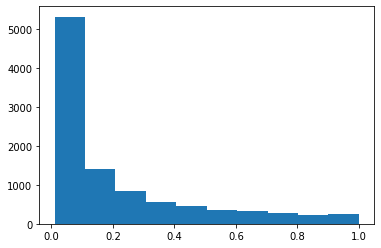

In [49]:
dist = stats.norm(10, 2) # if you have a best guess (say: 10)

dist = stats.randint(1, 100) # if you have no idea
dist = stats.uniform(1, 100) # same

dist = stats.loguniform(0.01, 1) # Coarse grain search

r = dist.rvs(size=10000) # Random draws
plt.hist(r);

## SVMs

In [50]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [51]:
svc = SVC(kernel='linear', C=10)
svc_bis = SGDClassifier(loss='hinge', penalty='l2', alpha=1/10)